In [11]:
# Загрузим всякие нужные модули
from scipy.misc import imread,imresize,imrotate
import matplotlib.pyplot as plt
%matplotlib inline
import os
import numpy as np


In [3]:
# Загрузим изображения разнообразных хорьков (по крайней мере то, что нашлось по этому запросу)
# Их чуть меньше 10000 штук

data_dir = "./weasels/"
img_names = os.listdir(data_dir)
img_paths = list(map(lambda fname: os.path.join(data_dir,fname),img_names))
img = imread(img_paths[100])

In [4]:
# Сожмём все картинки до размера 100*100, чтобы было удобнее с ними работать, 
# и запишем в numpy-массив

standard_size = (100,100)

resized_images = []
for i in range(len(img_names)) :
    resized_images.append(imresize(imread(img_paths[i]), standard_size))

resized_images = np.array(resized_images)

In [5]:
# Проверим, что всё получилось - посмотрим на форму массива :
# Первое число, не сильно меньшее 10000 - это количество картинок
# Две следующие сотни - это размер каждой картинки
# Последнее число - 3. Это три компонента цвета каждого пикселя (RGB - красный, зелёный, синий)

resized_images.shape

(9239, 100, 100, 3)

In [6]:
# Создадим функцию для вырезания из картинок размером 50*50 центральных квадратов 30*30

def get_square(imgs, x0=10,y0=10,w=30,h=30):
    squares = imgs[:,y0:y0+h,x0:x0+w]
    return squares
 

In [7]:
# Создадим функцию для формирования Х (данных, которые будут подаваться программе) 
# и Y (того, что программа должна предсказывать)
# Х - это те самые квадраты 30*30
# Y - это "бортики" шириной 10 пикселей, оставшиеся после вырезания квадратов (Х) из картинок
  
def get_XY(imgs,x0,y0,w,h,border_size,colors=3):
    
    X = get_square(imgs,x0,y0,w,h).reshape([-1,w*h*3])
    
    parts_x0 = [x0-border_size,x0, x0, x0+w]
    parts_y0 = [y0-border_size,y0-border_size, y0+h, y0-border_size]
    parts_w = [border_size,w,w,border_size]
    parts_h = [h+border_size*2, border_size,border_size,h+2*border_size]
    
    
    y_parts = map(get_square, [imgs]*4, parts_x0,parts_y0,parts_w,parts_h)
    
    y_parts = map(lambda part: part.reshape(len(imgs),-1),y_parts)
    y = np.concatenate(list(y_parts),axis=1)
    
    return X , y

In [8]:
# Нам нужно получить выборку побольше, чем имеющиеся 10000 картинок хорьков 100*100
# Поэтому мы будем размножать выборку - вырезать из каждой картинки 100*100 по 10 картинок 50*50 из разных мест
# И в конце запишем получившиеся X и Y в numpy-массивы

X_all = []
for i in range(10) :
    X_all.append(0)
y_all = []
for i in range(10) :
    y_all.append(0)
for i in range(10) :
    X_all[i], y_all[i] = get_XY(resized_images, 10+5*i, 10+5*i, 30, 30, border_size=10)
X_all = np.array(X_all)
y_all = np.array(y_all)
X_1 = []
y_1 = []
for i in range(10) :
    for j in range(len(X_all[i])) :
        X_1.append(X_all[i][j])
        y_1.append(y_all[i][j])
X = np.array(X_1)
y = np.array(y_1)

In [9]:
# Разделим все Х и Y на 2 группы - для тренировки алгоритма (train) и его тестирования (test)
# На X_train и Y_train наш алгоритм будет обучаться,
# то есть узнавать, какие "бортики" (Y) должны быть у квадратов (Х)
# А по X_test алгоритм должен будет предсказать Y ("бортики")
# Картинки делятся на train и test пополам случайным образом

from sklearn.cross_validation import train_test_split
np.random.seed(len(X))
X_train,X_test,Y_train,Y_test = train_test_split(X,y,test_size=0.5)

In [10]:
# Проверим, что получилось - например, форму тренировочной выборки Х_train.
# Первое число - примерно 46000 - количество картинок.
# Это половина от числа, получившегося после вырезания из каждой картинки нескольких.
# Второе число - 2700 - это размер каждой картинки из Х (30*30) умножить на 3 (цвета в RGB)

X_train.shape

(46195, 2700)

In [ ]:
# Ура! Создаём модель линейной регрессии - ту штуку, которая будет всё предсказывать!
# Потом обучаем её (fit) на train-выборке!
# И, наконец, она предсказывает все Y ("бортики") для тестовой выборки!
# Это занимает некоторое время, так как выборки относительно большие.

from sklearn.linear_model import LinearRegression
model = LinearRegression().fit(X_train,Y_train)
y_predicted = model.predict(X_test)


In [16]:
# Теперь нам придётся обработать полученные данные, то есть превратить массив в картинку 50*50.
# Создадим пустую картинку 50*50 и будем вклеивать в неё центр (Х) и бортики (Y).
# Их нужно фигурно вырезать из массива и придавать им вид пикселей нужного цвета.
# Функция возвращает многострадальную картинку-результат,
# склеенную из данного центра и предсказанных "бортиков"

def print_predicted_image (Num_of_img, X1, Y1) :

    full_picture = np.zeros([50,50,3])


    center = X1[Num_of_img]
    prediction = Y1[Num_of_img]

    offset = 0
    left_bar  = prediction[offset:offset+50*10*3]
    offset += 50*10*3
    upper_bar = prediction[offset:offset+10*30*3]
    offset += 10*30*3
    lower_bar = prediction[offset:offset+10*30*3]
    offset += 10*30*3
    right_bar = prediction[offset:offset+50*10*3]

    full_picture[:,  :10, :]     = left_bar.reshape([50,10,3])
    full_picture[:10,  10:40, :] = upper_bar.reshape([10,30,3])
    full_picture[40:,  10:40, :] = lower_bar.reshape([10,30,3])
    full_picture[:,  40:, :]     = right_bar.reshape([50,10,3])
    full_picture[10:40, 10:40, :] = center.reshape([30,30,3])

    return full_picture
    

In [14]:
# Научимся заодно рисовать исходную серединку без бортиков, по которой мы их предсказываем
# Просто, чтоб потом сравнить.

def print_not_predicted_image (Num_of_img, X1) :

    full_picture = np.zeros([50,50,3])
    center = X1[Num_of_img]
    full_picture[10:40, 10:40, :] = center.reshape([30,30,3])

    return full_picture


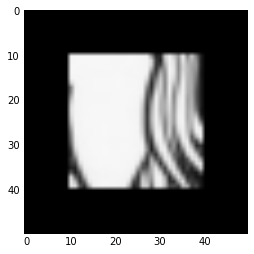

NameError: name 'y_predicted' is not defined

In [17]:
# И, наконец-то, мы закончили с преобразованием, и можем рисовать результат (первые 10 картинок)
# Сначала мы рисуем отдельно серединку, по которой мы предсказываем
# Потом, собственно, наш результат - серединку с предсказанными "бортиками"
# И, наконец, целую исходную картинку, которая бы получилась, будь наш алгоритм идеальным

for i in range(200) :
    plt.subplot(1,3,1)
    plt.imshow(print_not_predicted_image (i, X_test).astype('uint8'))
    plt.subplot(1,3,2)
    plt.imshow(print_predicted_image (i, X_test, y_predicted).astype('uint8'))
    plt.subplot(1,3,3)
    plt.imshow(print_predicted_image (i, X_test, Y_test).astype('uint8'))
    plt.show()

In [12]:
# Итак, всё работает!
# Правда, картинки получаются довольно размытыми и не всегда правильными.
# В том числе, кое-где возникают внезапные кляксы кислотного цвета.
# Они вызваны так называемым переобучением : алгоритм слишком "привыкает" к данной выборке 
# и не может хорошо предсказывать на новой.
# Чтобы улучшить качество, можно попробовать применять другие алгоритмы
# или же попробовать нарастить выборку - вырезать из каждой картинки больше маленьких 
# или слегка поворачивать их вокруг своей оси и т.п.
# 

(183, 275, 3)

(183, 275, 3)